In [282]:
#importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Importing data

In [283]:
# dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
# path_to_downloaded_file  = tf.keras.utils.get_file(fname = 'petfinder_mini.zip', origin = dataset_url, 
#                                                    extract=True, cache_dir = '.')
# print(path_to_downloaded_file)

In [284]:
csv_file_path = r'datasets\petfinder-mini\petfinder-mini.csv'
df = pd.read_csv(csv_file_path)

In [285]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64 
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64 
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64 
 14  AdoptionSpeed  11537 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 1.3+ MB


### Data Pre-processing

In [287]:
df.shape

(11537, 15)

In [288]:
df.AdoptionSpeed.value_counts(dropna = False)

2    3153
4    3080
3    2543
1    2432
0     329
Name: AdoptionSpeed, dtype: int64

In [289]:
#calculating a new target variable
df['target'] = df.AdoptionSpeed.apply(lambda x: 1 if x !=4 else 0)

In [290]:
df['target'].value_counts()

1    8457
0    3080
Name: target, dtype: int64

In [291]:
df.shape

(11537, 16)

In [292]:
df.drop(columns=['AdoptionSpeed', 'Description'], inplace = True)

In [293]:
df.shape

(11537, 14)

In [294]:
#splitting dataset using numpy split into 80%:10%:10%
#want to try sklearn here as stratfication can't be done using numpy
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [295]:
[round(x, 3) for x in (train.shape[0]/len(df), val.shape[0]/len(df), test.shape[0]/len(df))]

[0.8, 0.1, 0.1]

### Creating an input pipeline using tf.data

In [296]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: np.array(value)[:, tf.newaxis] for key, value in df.items()} #
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = ds.cardinality(), seed = 42)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [297]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [298]:
list((train_ds.as_numpy_iterator()))[0]

({'Type': array([[b'Dog'],
         [b'Cat'],
         [b'Dog'],
         [b'Cat'],
         [b'Cat']], dtype=object),
  'Age': array([[48],
         [ 3],
         [ 3],
         [ 4],
         [24]], dtype=int64),
  'Breed1': array([[b'Poodle'],
         [b'Domestic Short Hair'],
         [b'Mixed Breed'],
         [b'Domestic Medium Hair'],
         [b'Domestic Medium Hair']], dtype=object),
  'Gender': array([[b'Female'],
         [b'Female'],
         [b'Female'],
         [b'Female'],
         [b'Female']], dtype=object),
  'Color1': array([[b'Brown'],
         [b'Yellow'],
         [b'Black'],
         [b'Black'],
         [b'Black']], dtype=object),
  'Color2': array([[b'No Color'],
         [b'No Color'],
         [b'Brown'],
         [b'White'],
         [b'Yellow']], dtype=object),
  'MaturitySize': array([[b'Small'],
         [b'Small'],
         [b'Medium'],
         [b'Medium'],
         [b'Medium']], dtype=object),
  'FurLength': array([[b'Medium'],
         [b'Short'],


In [299]:
for example in train_ds.take(1):
    for name, value in example[0].items():
        print(f"{name}: {value}")
    break

Type: [[b'Dog']
 [b'Cat']
 [b'Cat']
 [b'Dog']
 [b'Cat']]
Age: [[2]
 [3]
 [3]
 [2]
 [5]]
Breed1: [[b'Mixed Breed']
 [b'Domestic Short Hair']
 [b'Domestic Short Hair']
 [b'Mixed Breed']
 [b'Siamese']]
Gender: [[b'Male']
 [b'Female']
 [b'Male']
 [b'Female']
 [b'Male']]
Color1: [[b'Black']
 [b'Black']
 [b'Golden']
 [b'Black']
 [b'Brown']]
Color2: [[b'No Color']
 [b'No Color']
 [b'No Color']
 [b'Brown']
 [b'Cream']]
MaturitySize: [[b'Medium']
 [b'Medium']
 [b'Medium']
 [b'Medium']
 [b'Medium']]
FurLength: [[b'Short']
 [b'Short']
 [b'Short']
 [b'Short']
 [b'Short']]
Vaccinated: [[b'No']
 [b'No']
 [b'No']
 [b'No']
 [b'Yes']]
Sterilized: [[b'No']
 [b'No']
 [b'No']
 [b'No']
 [b'No']]
Health: [[b'Healthy']
 [b'Healthy']
 [b'Healthy']
 [b'Healthy']
 [b'Healthy']]
Fee: [[0]
 [0]
 [0]
 [0]
 [0]]
PhotoAmt: [[5]
 [3]
 [1]
 [4]
 [6]]


In [300]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor(
[[ 3]
 [20]
 [12]
 [ 2]
 [ 1]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 0 1 1], shape=(5,), dtype=int64)


### Creating Pre-processing layers

In [301]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis = None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y : x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [302]:
photo_count_col = train_features['PhotoAmt']
print(photo_count_col)
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

tf.Tensor(
[[5]
 [2]
 [3]
 [4]
 [7]], shape=(5, 1), dtype=int64)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.4453224 ],
       [-0.5078774 ],
       [-0.19014412],
       [ 0.12758914],
       [ 1.080789  ]], dtype=float32)>

In [303]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens = None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens = max_tokens, output_mode = 'one_hot')
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens, output_mode = 'one_hot')

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    # print(index.get_vocabulary())
    # print(index.vocabulary_size())
    
    # return index

    # Encode the integer indices.
    # encoder = layers.CategoryEncoding(num_tokens = index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    # return lambda feature: encoder(index(feature))
    return index

In [304]:
df.Breed1.value_counts()

Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
                        ... 
Bedlington Terrier         1
American Bulldog           1
Rhodesian Ridgeback        1
Setter                     1
Dutch Shepherd             1
Name: Breed1, Length: 166, dtype: int64

In [305]:
test_type_col = train_features['Breed1']
test_type_layer = get_category_encoding_layer(name='Breed1', dataset = train_ds, dtype='string')
print(test_type_col)
test_type_layer(test_type_col)

tf.Tensor(
[[b'Mixed Breed']
 [b'Mixed Breed']
 [b'Domestic Short Hair']
 [b'Mixed Breed']
 [b'Domestic Medium Hair']], shape=(5, 1), dtype=string)


<tf.Tensor: shape=(5, 164), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [306]:
df.Age.value_counts()

2      2522
3      1500
1      1415
4       888
12      833
       ... 
135       1
44        1
92        1
74        1
100       1
Name: Age, Length: 105, dtype: int64

In [307]:
test_age_col = train_features['Age']
print(test_age_col)
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=None)
test_age_layer(test_age_col)

tf.Tensor(
[[ 3]
 [20]
 [12]
 [ 2]
 [ 1]], shape=(5, 1), dtype=int64)


<tf.Tensor: shape=(5, 102), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

### Setting up data for the model

In [308]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Numerical Inputs: Preprocessing

In [309]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header, dtype=tf.float32)
    # print(numeric_col)    
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

### Age: Preprocessing

In [310]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=None)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [311]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>]

In [312]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_13')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_14')>,
 <KerasTensor: shape=(None, 102) dtype=float32 (created by layer 'integer_lookup_9')>]

### Categorical Inputs: Preprocessing

In [313]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype=tf.string)
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=None)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [314]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>]

In [315]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_13')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_14')>,
 <KerasTensor: shape=(None, 102) dtype=float32 (created by layer 'integer_lookup_9')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'string_lookup_45')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'string_lookup_46')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'string_lookup_47')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'string_lookup_48')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_49')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_50')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_51')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_52')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 

In [316]:
all_features = tf.keras.layers.concatenate(encoded_features)
all_features

<KerasTensor: shape=(None, 310) dtype=float32 (created by layer 'concatenate_4')>

### Model Building

In [317]:
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [318]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 PhotoAmt (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 Fee (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Type (InputLayer)           [(None, 1)]                  0         []                            
                                                                                            

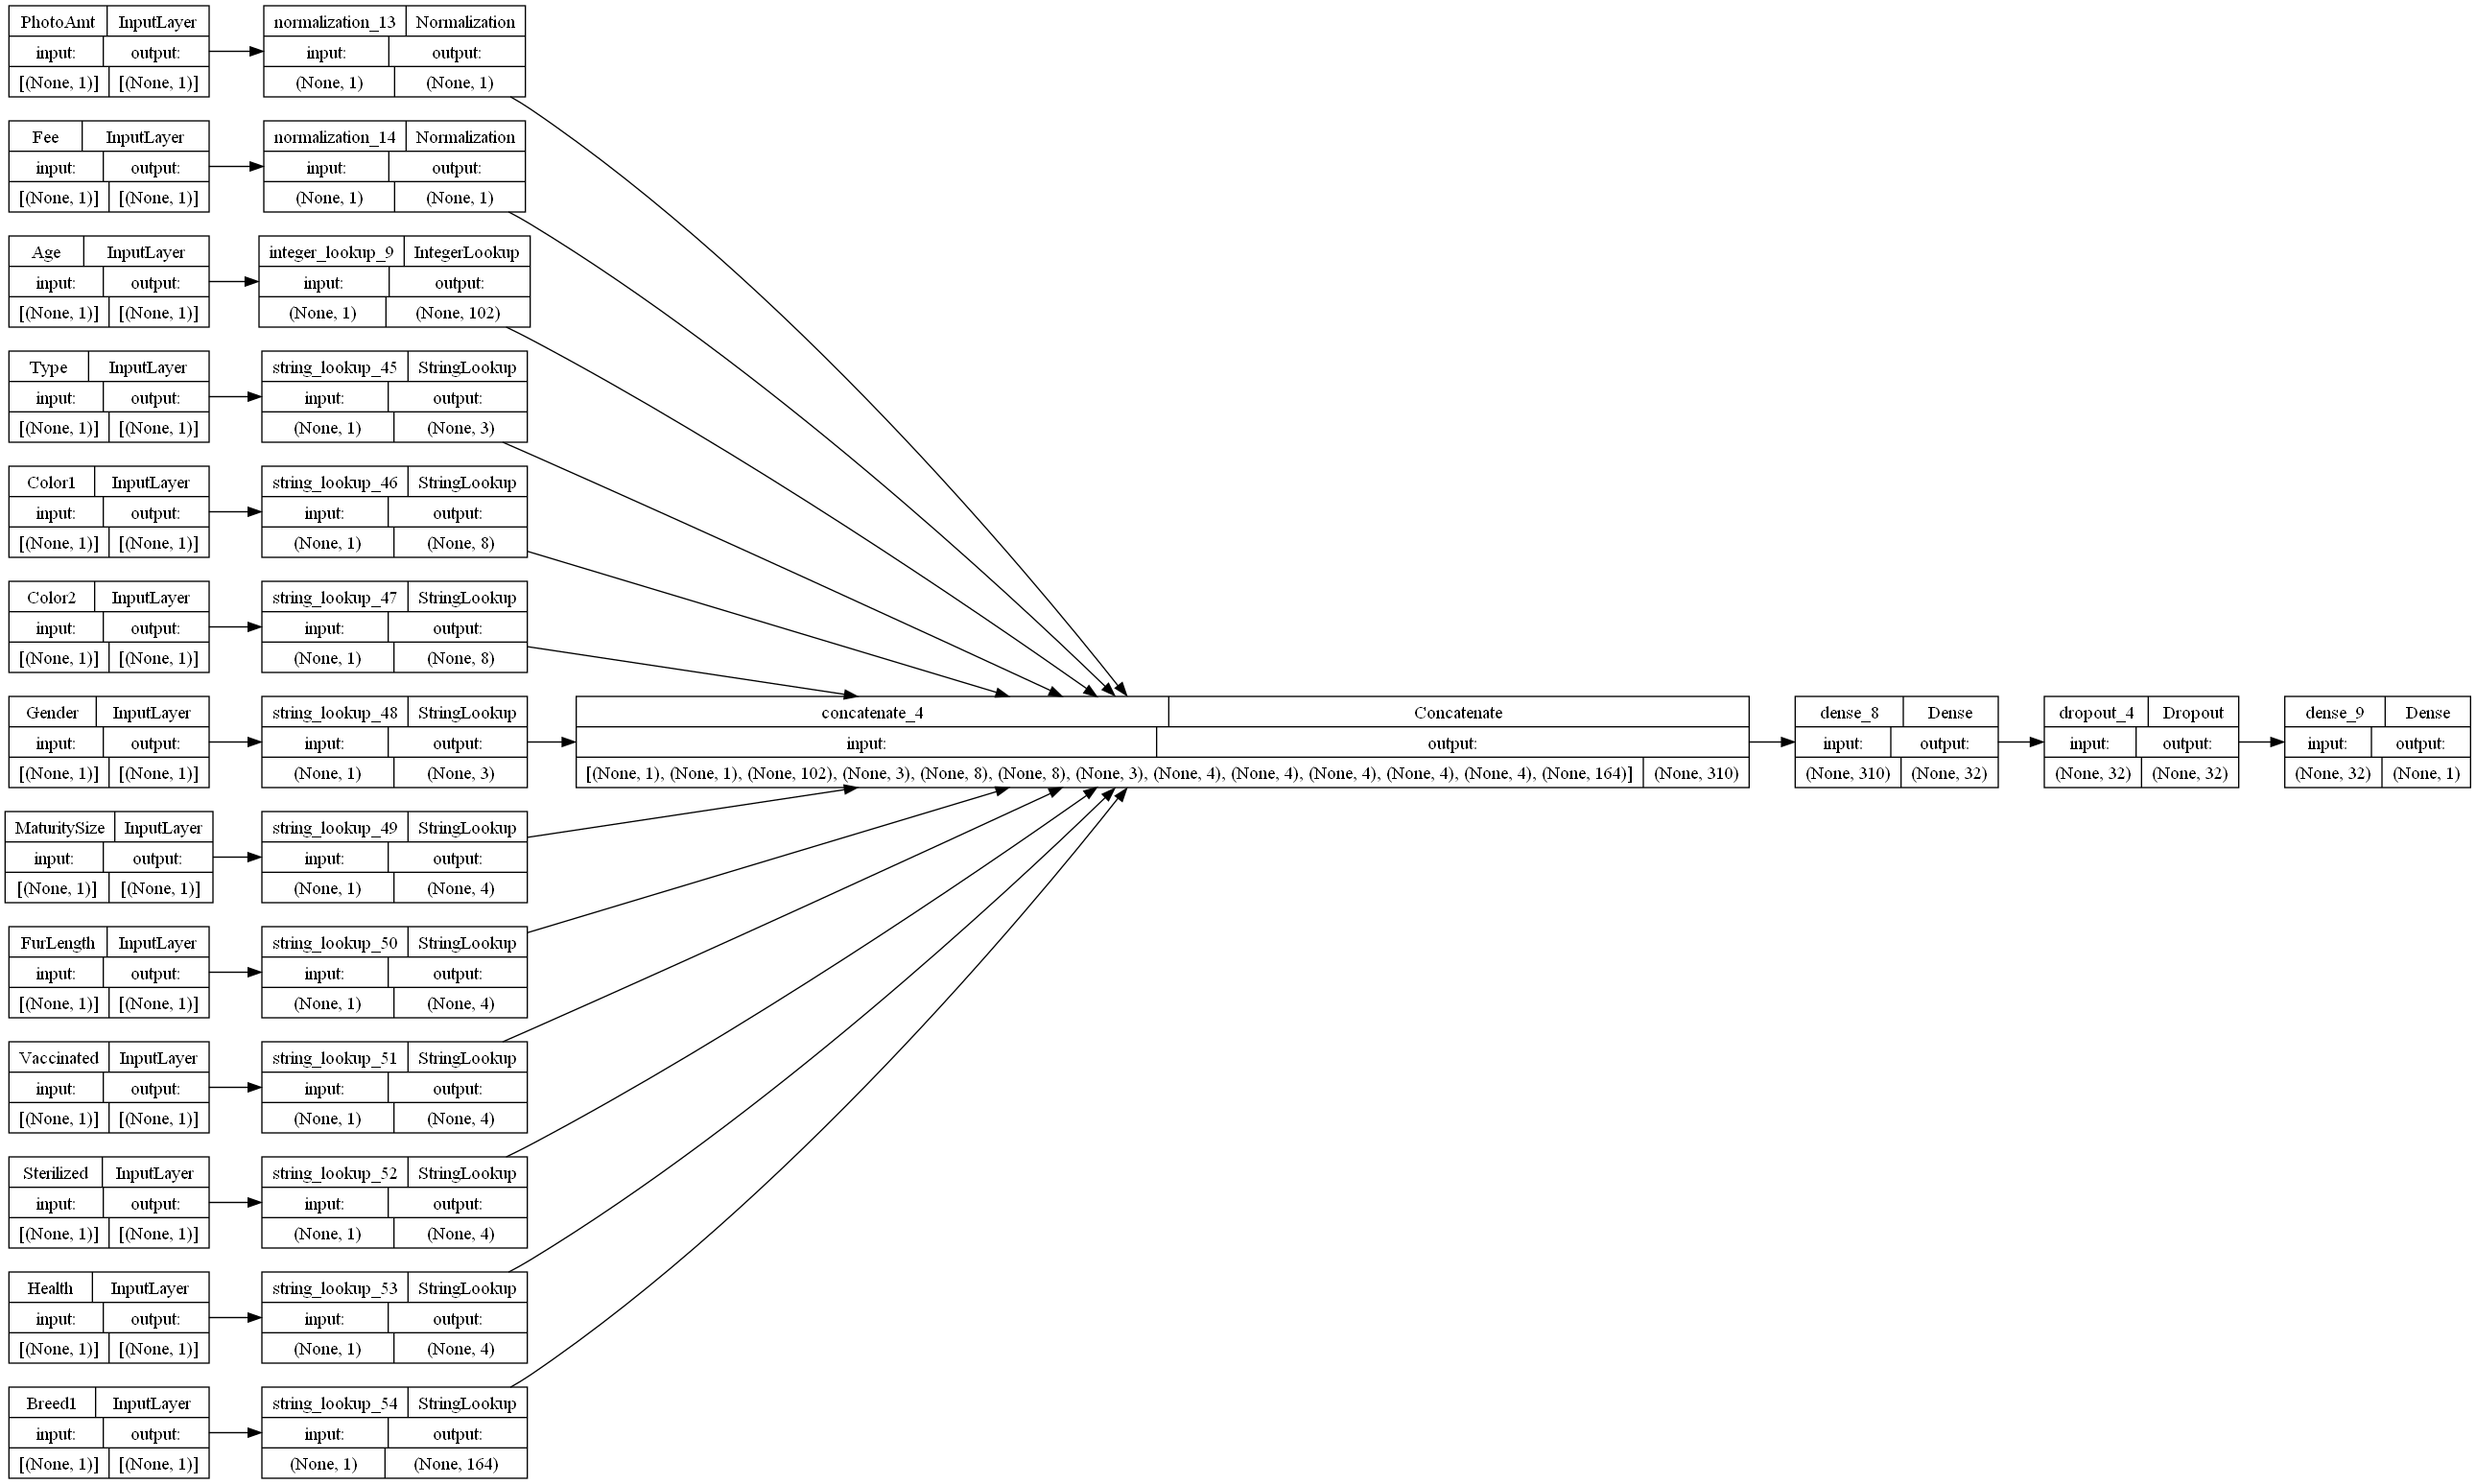

In [319]:
tf.keras.utils.plot_model(
    model,
    to_file='model_image/pet_adoption_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',
    dpi=96,
    layer_range=None,
)

In [320]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [321]:
history = model.fit(train_ds, epochs=100, verbose = 2, validation_data = val_ds)

Epoch 1/100
37/37 - 2s - loss: 0.6253 - accuracy: 0.6734 - val_loss: 0.5784 - val_accuracy: 0.7253 - 2s/epoch - 52ms/step
Epoch 2/100
37/37 - 0s - loss: 0.5701 - accuracy: 0.7336 - val_loss: 0.5585 - val_accuracy: 0.7253 - 186ms/epoch - 5ms/step
Epoch 3/100
37/37 - 0s - loss: 0.5558 - accuracy: 0.7326 - val_loss: 0.5463 - val_accuracy: 0.7253 - 169ms/epoch - 5ms/step
Epoch 4/100
37/37 - 0s - loss: 0.5451 - accuracy: 0.7341 - val_loss: 0.5379 - val_accuracy: 0.7253 - 156ms/epoch - 4ms/step
Epoch 5/100
37/37 - 0s - loss: 0.5330 - accuracy: 0.7363 - val_loss: 0.5313 - val_accuracy: 0.7331 - 167ms/epoch - 5ms/step
Epoch 6/100
37/37 - 0s - loss: 0.5308 - accuracy: 0.7422 - val_loss: 0.5261 - val_accuracy: 0.7366 - 155ms/epoch - 4ms/step
Epoch 7/100
37/37 - 0s - loss: 0.5238 - accuracy: 0.7461 - val_loss: 0.5223 - val_accuracy: 0.7340 - 172ms/epoch - 5ms/step
Epoch 8/100
37/37 - 0s - loss: 0.5200 - accuracy: 0.7491 - val_loss: 0.5194 - val_accuracy: 0.7331 - 181ms/epoch - 5ms/step
Epoch 9/10

### Model Analysis

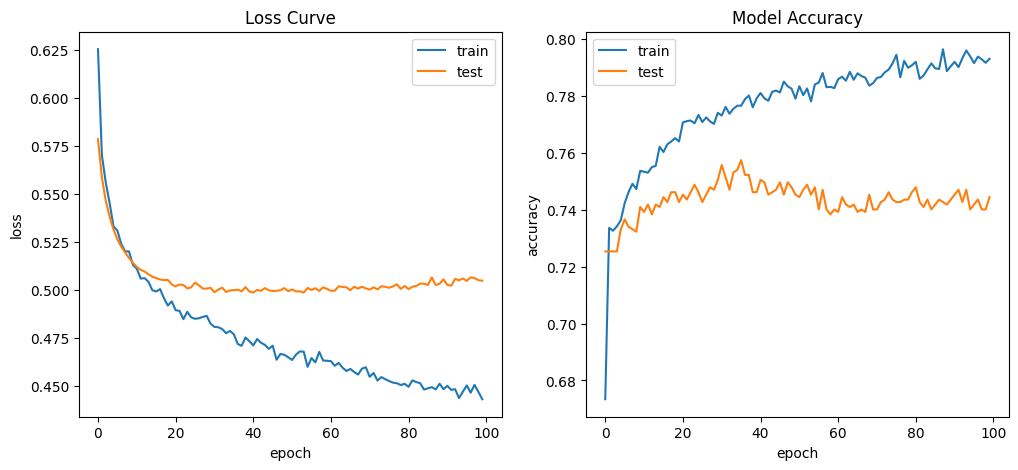

In [322]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss Curve')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test']);

In [323]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", round(accuracy, 3))

5/5 [==============================] - 0s 3ms/step - loss: 0.5129 - accuracy: 0.7539
Accuracy 0.754


In [324]:
model.save('my_pet_classifier.keras')
reloaded_model = tf.keras.models.load_model('my_pet_classifier.keras')

### Inference

In [325]:
sample = {
    'Type': 'Cat',
    'Age': 238,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Serious Injury',
    'Fee': 100,
    'PhotoAmt': 2,
}

In [326]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

In [327]:
input_dict

{'Type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Cat'], dtype=object)>,
 'Age': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([238])>,
 'Breed1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Tabby'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Male'], dtype=object)>,
 'Color1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Black'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'White'], dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Small'], dtype=object)>,
 'FurLength': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Short'], dtype=object)>,
 'Vaccinated': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'No'], dtype=object)>,
 'Sterilized': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'No'], dtype=object)>,
 'Health': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Serious Injury'], dtype=object)>,
 'Fee': <tf.Tensor: shape=(1,

In [328]:
predictions = reloaded_model.predict(input_dict)

1/1 [==============================] - 0s 337ms/step


In [334]:
round(predictions[0][0], 4)

0.16